In this notebook, we will illustrate how to cluster a larger number of points in analyzing Chicago crime data.

datafile: Violence.csv

<h3> 1. Example</h3>
As usual, we begin with the imports that we will need for this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import json # library to handle JSON files
import requests # library to handle requests
import folium # map rendering library

1)  Read in recent data for 1,000 violent crime occurrences specified by the latitude-longitude location of each incident.

In [2]:
# read from excel file, dropping all entries with N/A values
violence = pd.read_csv('Violence.csv').dropna(subset = ['LATITUDE', 'LONGITUDE'])

# Streamline columns to just latitude and longitude, reduce to just first 1000 entries
violence = violence[['LATITUDE', 'LONGITUDE']].head(1000)

# Reset the index for consistent numbering
violence = violence.reset_index(drop = True)
print("Size of Dataset", violence.shape)
violence.head(5)

Size of Dataset (1000, 2)


,LATITUDE,LONGITUDE
0,41.865451,-87.725050
1,41.874441,-87.717590
2,41.923618,-87.803495
3,41.800621,-87.663270
4,41.865637,-87.720071


2) Next, we map the 1,000 recorded instances to see what we are working with.

In [3]:
chi_map = folium.Map(location=[41.783, -87.621],  tiles="Stamen Toner", zoom_start=10)  #create a basemap

for i in np.arange(0,1000,1):  #add parcel data one
    p=[violence.loc[i,"LATITUDE"],violence.loc[i,"LONGITUDE"]]# by one to the base map.
    folium.CircleMarker(p, radius=1, color = 'gray').add_to(chi_map)
chi_map

3) We've provided a function that will allow you to test different numbers of clusters for the same data. For the purposes of this lab, up to 100 clusters can be used. We will use this function to visualize 22 clusters since there are 22 police districts in Chicago.

In [4]:
# Get the 100 colors used to identify clusters
colorlist = list(mcolors.XKCD_COLORS.values())[:100]

# Make a map that uses k-means clustering to divide locations into up to 100 clusters 
#the inout variable (clusters) specifies the number of clusters. 
#the input variable data specifies the locations.
def make_map(clusters,data):
    assert clusters >= 1, "Number of clusters must be at least 1"
    assert clusters <= len(colorlist), "Number of clusters exceeds maximum amount"
    x=data[['LATITUDE', 'LONGITUDE']]
    k_means = KMeans(n_clusters=clusters)
    k_means.fit(x)
    k_means_labels = k_means.labels_
    
    x['labels'] = k_means_labels
    k_map = folium.Map(location=[41.783, -87.621],  tiles="Stamen Toner", zoom_start=10)

    for i in np.arange(0,len(x),1):  #add parcel data one
        p=[x.loc[i,"LATITUDE"],x.loc[i,"LONGITUDE"]]# by one to the base map.
        k_map.add_child(folium.CircleMarker(p, radius=1,color=colorlist[x.loc[i, 'labels']], fill = True, fill_opacity = 1))
    return   k_map

4) Let's use make_map() to divide the locations into two parts.

In [5]:
make_map(2,violence)

Now, we will compare the police district boundaries in Chicago to the 22 clusters our k-means algorithm comes up with.

Note that the I55 Expressway which runs northeast from Summit to Chicago is an approximate dividing line between the clusters on the South and West sides of Chicago.

<h2> 2. Assignment</h2>
Use k-means to divide the crime data into 22 clusters.  How does the result compare
with a map of the 22 Chicago Police Deparftment districts>

<h4>Solution</h4>

Let's take a look at the 22 clusters.

In [6]:
cluster22_map = make_map(22,violence)
cluster22_map

Here is a map of the districts.

C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


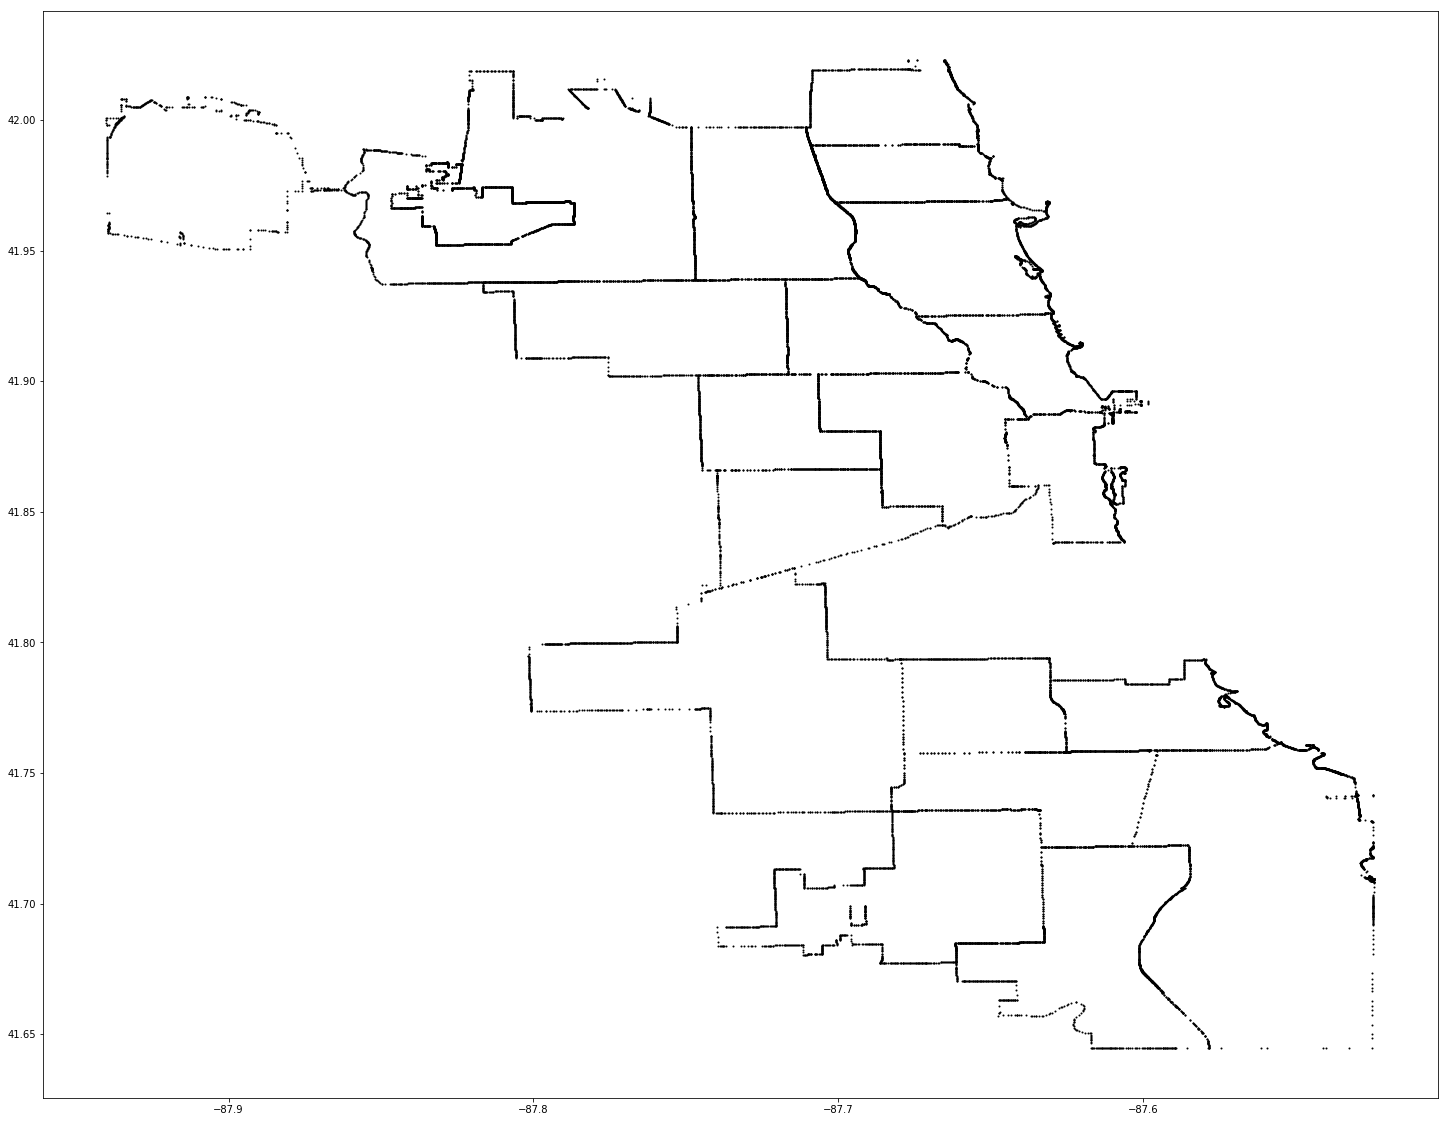

In [7]:
with open('CPDdistricts.geojson') as json_data:
    district_data = json.load(json_data)
districts=district_data['features']
#initialize the plot dimensions
fig=plt.figure(figsize=(25,20))
#create a plot axis
ax=fig.add_subplot(1,1,1)
#add the beat boundaries
ind=0
while (ind<22):
    for coordlist in districts[ind]['geometry']['coordinates']:
        data=np.array(coordlist)
        flat=[]
        for i in data:
            for j in i:
                flat.append(j)
        x,y=np.array(flat).T
        ax.plot(x,y,'o',markerfacecolor='k',markeredgecolor='k',markersize=1)
        ind+=1

Let's add the Cluster number to each location.

In [8]:
k_means = KMeans(n_clusters=22)
k_means.fit(violence)
k_means_labels = k_means.labels_
violence["Cluster"] = k_means_labels
violence.head()

,LATITUDE,LONGITUDE,Cluster
0,41.865451,-87.725050,10
1,41.874441,-87.717590,10
2,41.923618,-87.803495,18
3,41.800621,-87.663270,21
4,41.865637,-87.720071,10


Now we can add the cluster numbers to the district boundary map.

C:\Users\pisihara\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


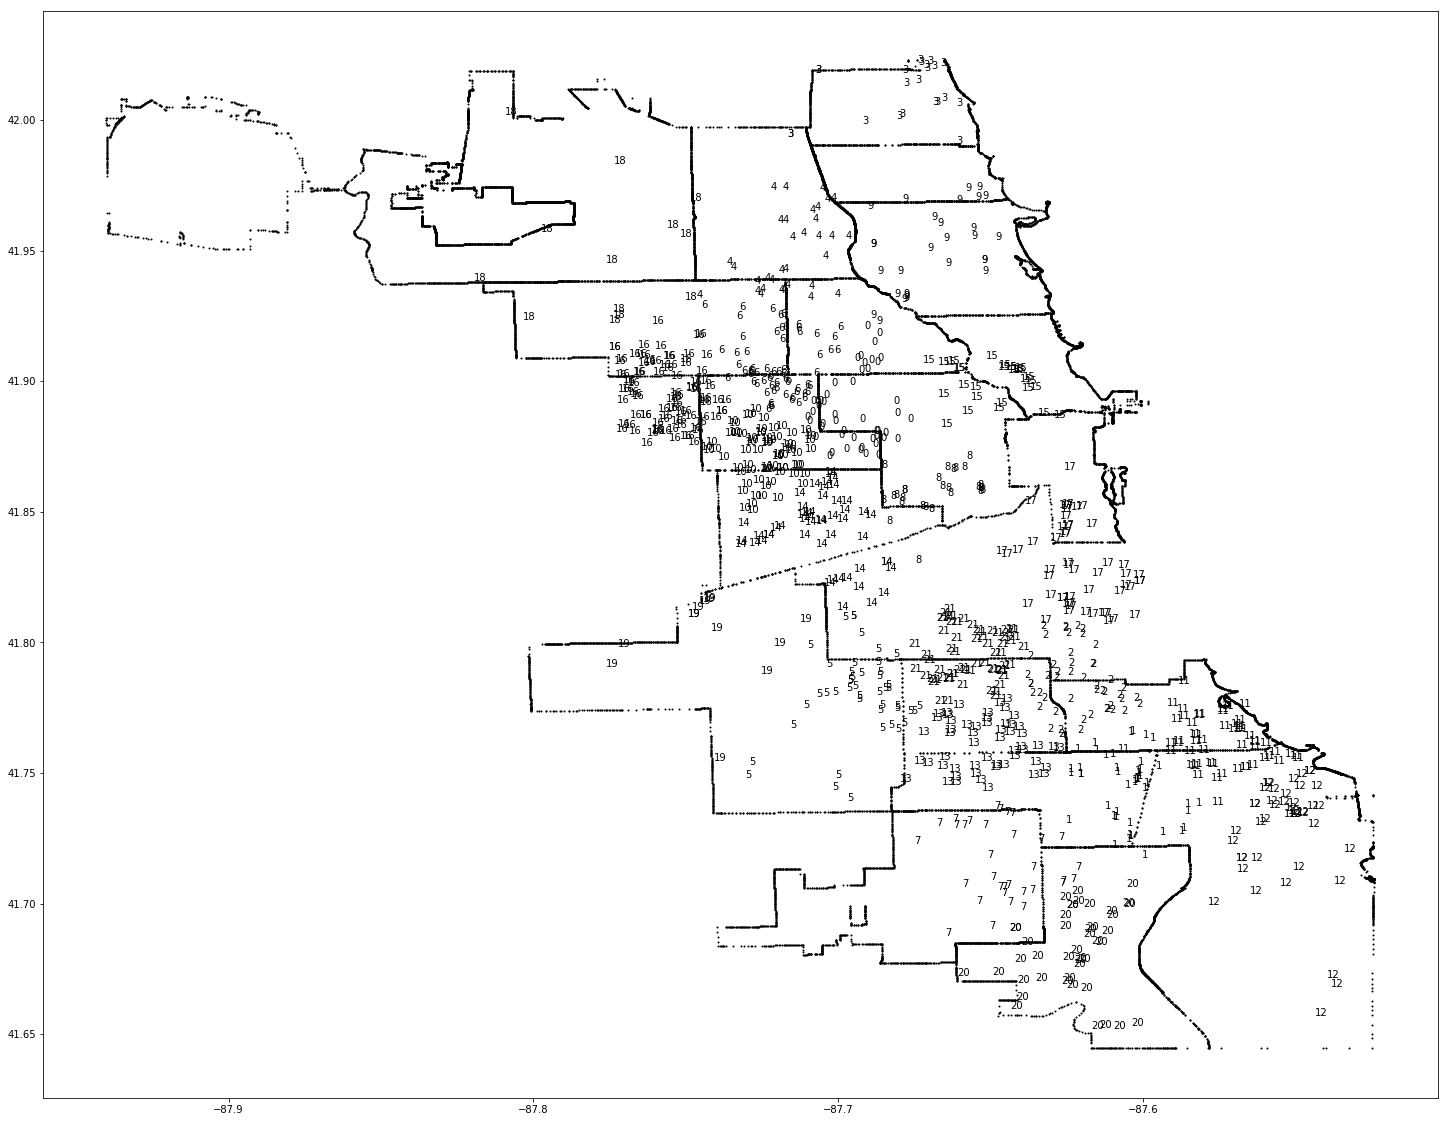

In [9]:
fig=plt.figure(figsize=(25,20))
#create a plot axis
ax=fig.add_subplot(1,1,1)
#add the clusters

for i in violence.index:
    plt.text(violence.loc[i,"LONGITUDE"],violence.loc[i,"LATITUDE"],str(violence.loc[i,"Cluster"]))


#add the beat boundaries
ind=0
while (ind<22):
    for coordlist in districts[ind]['geometry']['coordinates']:
        data=np.array(coordlist)
        flat=[]
        for i in data:
            for j in i:
                flat.append(j)
        x,y=np.array(flat).T
        ax.plot(x,y,'o',markerfacecolor='k',markeredgecolor='k',markersize=1)
        ind+=1

While it is not perfect, our k-means algorithm clustered the violent occurrences in a similar manner to the police district boundaries.
